In [1]:
import networkx as nx
import duckdb

import pandas as pd
import matplotlib.pyplot as plt
from pycelonis import get_celonis

url = "https://louis-herrmann-rwth-aachen-de.training.celonis.cloud"
api = "NWE2NjdjOGEtYTkyMS00NDYyLTk0M2EtZjFiYjdhZDA5MTYzOmZJSDIydFd3TEwrQkUwV2tBVkhtN0N5VFI1aHdWYVJ2TDJVUWpoL2U5cUE4"

celonis = get_celonis(url, api)

ERROR:pycelonis:Couldn't connect to IBC, trying to switch key type...


2022-01-22 12:16:42 - pycelonis: Login successful! Hello Louis. PyCelonis Version: 1.5.14
2022-01-22 12:16:43 - pycelonis: Your key has following permissions:
[
    {
        "permissions": [
            "EDIT_ALL_SPACES",
            "MANAGE_PERMISSIONS",
            "CREATE_SPACE",
            "DELETE_ALL_SPACES"
        ],
        "serviceName": "package-manager"
    },
    {
        "permissions": [
            "EDIT_AGENTS",
            "VIEW_AGENTS",
            "REGISTER_AGENTS",
            "MANAGE_PERMISSIONS"
        ],
        "serviceName": "workflows"
    },
    {
        "permissions": [
            "EDIT_CLIENT_SETTINGS",
            "EDIT_USERS"
        ],
        "serviceName": "task-mining"
    },
    {
        "permissions": [
            "MANAGE_SSO_SETTINGS",
            "USE_AUDIT_LOGS_API",
            "MANAGE_GENERAL_SETTINGS",
            "MANAGE_GROUPS",
            "MANAGE_APPLICATIONS",
            "MANAGE_LICENSE_SETTINGS",
            "MANAGE_MEMBERS",
   

In [2]:
data_pool = celonis.pools.find("OCEL_Pool1")
data_model = data_pool.datamodels.find("OCEL_Model1")

In [3]:
class Table:
    # should data model be a celonis data model or own class?
    def __init__(self, name, data_model, data=None):
        self.name = name
        self.data_model = data_model
        self.foreignKeys = {"as_source": [], "as_target": []}
        for dictionary in data_model.foreign_keys.find_keys_by_source_name(name):
            self.foreignKeys["as_source"].append(dictionary)
        for dictionary in data_model.foreign_keys.find_keys_by_target_name(name):
            self.foreignKeys["as_target"].append(dictionary)
        
        self.data = data
    
    def fetchData(self):
        if self.data is None:
            self.data = data_model.tables.find(self.name).get_data_frame()
    
    def getData(self):
        # return dataframe, if data doesn't exist yet, get from celonis
        if self.data is None:
            self.fetchData()
        return self.data

In [4]:
class ActivityTable(Table):
        
    def __init__(self, *args): # args: [name, data_model, data, actColumn, caseColumn, timestampColumn]
        if len(args) < 2:
            print("ActivityTable constructor needs more arguments")
        name = args[0]
        data_model = args[1]
        data = None
        if len(args) >= 3:
            data = args[2]
        super().__init__(name, data_model, data)
        
        self.activity_column = None
        self.timestamp_column = None
        self.case_column = None
                
        self.caseTable = None
        if len(args) <= 3:
            activity_table = None
            for table in data_model.process_configurations:
                if table.activity_table.name == name:
                    activity_table = table
                    break
            if activity_table:
                self.activity_column = activity_table.activity_column
                self.timestamp_column = activity_table.timestamp_column
                self.case_column = activity_table.case_column
                self.caseTable = activity_table.case_table.name
        elif len(args) == 6:
            # maybe create case table and set foreign key relation (can do this since we have data)
            self.activity_column = args[3]
            self.case_column = args[4]
            self.timestamp_column = args[5]


    def getData(self, shortened_columns=False):
        if self.data is None:
            self.fetchData()
        
        # return short-version of column names: "ACTIVITY", "TIMESTAMP", "OBJECTS"
        if shortened_columns:
            copy = self.data.copy(deep=True)
            copy.rename(columns = {self.activity_column: "ACTIVITY", self.timestamp_column: "TIMESTAMP", self.case_column: "OBJECTS"}, inplace = True)
            return copy
        return self.data

In [5]:
class Tables:
    def __init__(self):
        self.collection = []
    
    def addTable(self, table):
        self.collection.append(table)
    
    def removeTable(self, table):
        self.collection.remove(table)

    def removeByName(self, name):
        for i in self.collection:
            if i.name == name:
                self.collection.remove(i)
      
    def output(self):
        return [table.name for table in self.collection]

    # returns first occurence
    def find(self, name):
        for table in self.collection:
            if table.name == name:
                return table

In [6]:
class DataModel:

    def __init__(self, data_model):
        self.data_model = data_model
        
        self.tables = Tables()
        self.activity_tables = Tables()
        
        print("Fetching process configurations...")
        for table in data_model.process_configurations:
            self.activity_tables.addTable(ActivityTable(table.activity_table.name, data_model))

        print("Creating tables...")
        for table in data_model.tables:
            act = self.activity_tables.find(table.name)
            if act is not None:
                self.tables.addTable(act)
            else:        
                self.tables.addTable(Table(table.name, data_model))
        
        print("Fetching foreign keys...")
        self.foreignKeys = data_model.foreign_keys
        
        print("Creating foreign key graph...")
        self.foreignKeyGraph = None

        self.updateForeignKeyGraph()
        
        self.objectRelationships = {}
        
        
    def updateForeignKeyGraph(self):
        # create graph of all foreign key relations
        graph = {}
        for table in self.tables.collection:
            connected_nodes = []
            for dictionary in table.foreignKeys["as_source"]:
                connected_nodes.append(dictionary["target_table"])
            for dictionary in table.foreignKeys["as_target"]:
                connected_nodes.append(dictionary["source_table"])
            graph[table.name] = connected_nodes

        G = nx.Graph()
        for i in graph:
            G.add_node(i)
            for j in graph[i]:
                G.add_edge(i, j)
        
        self.foreignKeyGraph = G
    
        
    def calcForeignKeyPath(self, table1, table2):
        # find shortest path of tables from table1 to table2 based on foreign keys
        try: 
            return nx.algorithms.shortest_paths.generic.shortest_path(self.foreignKeyGraph, source=table1, target=table2)
        except:
            print("No path found")
            return []

            
    def calcMergePath(self, table1, table2):
        # create list of foreign key relations based on shortest path between table1 and table2
        # mergePath format: [{"leftTable": table1, "leftColumn": column1, "rightTable": table2, "rightColumn": column2}, {"leftTable": table3, "leftColumn": column3, "rightTable": table4, "rightColumn": column4}]
        path = self.calcForeignKeyPath(table1, table2)
        
        if len(path) == 0:
            return
        
        potential_relations2 = self.tables.find(path[0]).foreignKeys["as_source"] + self.tables.find(path[0]).foreignKeys["as_target"]

        mergePath = []
        for i in range(len(path)-1):
            potential_relations1 = potential_relations2
            potential_relations2 = self.tables.find(path[i+1]).foreignKeys["as_source"] + self.tables.find(path[i+1]).foreignKeys["as_target"]
            key_relation = {}
            for relation in potential_relations1:
                if relation in potential_relations2:
                    key_relation = relation
                    break
            if key_relation == {}:
                print("No Relation Found!")
                return mergePath
            mergePath.append({"leftTable": key_relation["source_table"], "leftColumn": key_relation["columns"][0][0], 
                              "rightTable": key_relation["target_table"], "rightColumn": key_relation["columns"][0][1]})
        return mergePath
    
    
    def calcObjectRelationships(self, actTableName1, actTableName2):
        # create table with relationship between two activity tables
        # basically takes all intermediate tables and returns one connector table
        if not self.isActivityTable(actTableName1) or not self.isActivityTable(actTableName2):
            return
        
        if (actTableName1, actTableName2) in self.objectRelationships:
            return self.objectRelationships[(actTableName1, actTableName2)]        
        
        actTable1 = self.activity_tables.find(actTableName1)
        actTable2 = self.activity_tables.find(actTableName2)
        
        mergePath = self.calcMergePath(actTableName1, actTableName2)

        df = actTable1.getData()
        for relation in mergePath:
            df = df.merge(self.tables.find(relation["leftTable"]).getData() \
                .merge(self.tables.find(relation["rightTable"]).getData(), \
                       left_on=relation["leftColumn"], right_on=relation["rightColumn"]))
        
        columns_to_keep = [actTable1.case_column, actTable2.case_column]
        
        df = df[list(set(columns_to_keep).intersection(df.columns))]
        
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        self.objectRelationships[(actTableName1, actTableName2)] = df
        # save table as actual Table() object including foreign keys to activity tables...
        return df

    
    def groupEvents(self, actTableName):
        # group all events with same activity and timestamp in activity table
        
        if not self.isActivityTable(actTableName):
            return
        # group events in table with same timestamp + activity name
        table = self.activity_tables.find(actTableName)
        
        grouped = self.tables.find("GROUP" + "{" + actTableName + "}")
        if grouped is not None:
            return grouped
        
        events = {}

        for ev in table.getData().to_dict("records"):
            evv = (ev[table.activity_column], ev[table.timestamp_column])
            if evv not in events:
                events[evv] = frozenset()
            if isinstance(ev[table.case_column],frozenset):
                events[evv] = events[evv].union(ev[table.case_column])
            else:
                events[evv] = events[evv].union(frozenset([ev[table.case_column]]))

        df = []
        
        newName = "GROUP" + "{" + actTableName + "}"
        for key, val in events.items():
            df.append( {newName + "_OBJECTS": val, newName + "_ACTIVITY": key[0], newName + "_TIMESTAMP": key[1]} )
        
        # adding to tables/activityTables collection
        actTable = ActivityTable(newName, self.data_model, 
                                 pd.DataFrame(df), newName + "_ACTIVITY", newName + "_OBJECTS", newName + "_TIMESTAMP")
        self.tables.addTable(actTable)
        self.activity_tables.addTable(actTable)
        
        self.createConnectionTable(table.name, actTable.name)
        
        # also group other attributes...
        return actTable
        


    def union(self, actTableName1, actTableName2):
        # create one merged activity table based on table relationships, timestamp, and activity names
        
        if not self.isActivityTable(actTableName1) or not self.isActivityTable(actTableName2):
            return
        
        table1 = self.activity_tables.find(actTableName1)
        table2 = self.activity_tables.find(actTableName2)
        
        union = self.tables.find("UNION_{" + actTableName1 + "}_AND_{" + actTableName2 + "}")
        if union is not None:
            return union
        
        relationship = self.calcObjectRelationships(actTableName1, actTableName2)

        df = table1.getData().merge(relationship, on=table1.case_column) \
                            .merge(table2.getData(), 
                                   left_on=[table2.case_column, table1.activity_column, table1.timestamp_column], 
                                   right_on=[table2.case_column, table2.activity_column, table2.timestamp_column])

        
        newDf2 = table2.getData()[[table2.case_column, table2.activity_column, table2.timestamp_column]].copy(deep=True)
        newDf2.columns = ["OBJECTS", "ACTIVITY", "TIMESTAMP"]
        
        group = {}
        
        for row in df.to_dict("records"):
            key = (row[table1.case_column], row[table1.activity_column], row[table1.timestamp_column])
            if key not in group:
                group[key] = frozenset()
            if isinstance(row[table2.case_column],frozenset):
                group[key] = group[key].union(row[table2.case_column])
            else:
                group[key] = group[key].union([row[table2.case_column]])
            i = newDf2[((newDf2.OBJECTS == row[table2.case_column]) &( newDf2.TIMESTAMP == key[2]) & (newDf2.ACTIVITY == key[1]))].index
            newDf2.drop(i, inplace=True)
            
        newDf = table1.getData()[[table1.case_column, table1.activity_column, table1.timestamp_column]]
        newDf.columns = ["OBJECTS", "ACTIVITY", "TIMESTAMP"]
        
        newDf = newDf.append(newDf2).reset_index(drop=True)
        
        
        for index, row in newDf.iterrows():
            key = (row["OBJECTS"], row["ACTIVITY"],row["TIMESTAMP"])
            if key in group:
                if isinstance(newDf.at[index, "OBJECTS"], frozenset):
                    newDf.at[index, "OBJECTS"] = newDf.at[index, "OBJECTS"].union(group[key])
                else:
                    newDf.at[index, "OBJECTS"] = frozenset([newDf.at[index, "OBJECTS"]]).union(group[key])
            else:
                # if no new objects will be added
                if not isinstance(newDf.at[index, "OBJECTS"], frozenset):
                    newDf.at[index, "OBJECTS"] = frozenset([newDf.at[index, "OBJECTS"]])

        newDf = newDf.sort_values(by='TIMESTAMP').reset_index(drop=True)
        
        newName = "UNION_{" + actTableName1 + "}_AND_{" + actTableName2 + "}"
        newDf.columns = [newName + "_OBJECTS", newName + "_ACTIVITY", newName + "_TIMESTAMP"]

        activityTable = ActivityTable(newName, self.data_model, newDf, newName + "_ACTIVITY", newName + "_OBJECTS", newName + "_TIMESTAMP")
        self.tables.addTable(activityTable)
        self.activity_tables.addTable(activityTable)
        
        # create connection tables
        for table in [table1, table2]:
            self.createConnectionTable(table.name, activityTable.name)
        
        # what about other attributes?
        
        return activityTable

    
    def createConnectionTable(self, actTableName1, actTableName2):
        # create a connector table between the two activity tables
        # also add foreign key relations and update foreign key graph
        
        if not self.isActivityTable(actTableName1) or not self.isActivityTable(actTableName2):
            return
        
        table1 = self.activity_tables.find(actTableName1)
        table2 = self.activity_tables.find(actTableName2)

        unique = []
        for obj in table1.getData()[table1.case_column]:
            if obj not in unique:
                unique.append(obj)

        values = []
        for i in range(len(unique)):
            for j in table2.getData()[table2.case_column]:
                if isinstance(unique[i],frozenset):
                    u_set = unique[i]
                else:
                    u_set = frozenset([unique[i]])
                if isinstance(j,frozenset):
                    j_set = j
                else:
                    j_set = frozenset([j])
                    
                if u_set.intersection(j_set) != frozenset():
                    values.append((j, unique[i]))
        data = pd.DataFrame(values, columns=[table2.name + "_COLUMN", table1.name + "_COLUMN"])
        data.drop_duplicates(inplace=True)
        data.reset_index(drop=True, inplace=True)
            
        newTable = Table("CONNECT_{" + table2.name + "}_AND_{" + table1.name +"}", self.data_model, data)
            
        # add foreign keys
        newTable.foreignKeys["as_target"].append({'source_table': table2.name,
                                                       'target_table': newTable.name,
                                                       'columns': [(table2.case_column, table2.name + "_COLUMN")]})
        table2.foreignKeys["as_source"].append({'source_table': table2.name,
                                                       'target_table': newTable.name,
                                                       'columns': [(table2.case_column, table2.name + "_COLUMN")]})
        newTable.foreignKeys["as_source"].append({'source_table': newTable.name,
                                                       'target_table': table1.name,
                                                       'columns': [(table1.name + "_COLUMN", table1.case_column)]})
        table1.foreignKeys["as_target"].append({'source_table': newTable.name,
                                                       'target_table': table1.name,
                                                       'columns': [(table1.name + "_COLUMN", table1.case_column)]})
        self.tables.addTable(newTable)
        
        self.updateForeignKeyGraph()
        
        return newTable
    
    
    def isActivityTable(self, tableName):
        # check whether table is in activity_tables collection
        if self.activity_tables.find(tableName) is not None:
            return True
        print(tableName + " is not Activity Table")
        return False
    
    
    def groupSpecificEvents(self, actTableName, events):
        # instead of grouping entire table, only group specific events
        # events parameter is collection of events {o:o, a:a, t:t}
        # for filters, could for example leave object, actvity, or timestamp column of event empty
        if not self.isActivityTable(actTableName):
            return
        
        table = self.activity_tables.find(actTableName)

        grouped = self.tables.find("GROUP_SPECIFIC" + str(events) + "{" + actTableName + "}")
        if grouped is not None:
            return grouped
        
        data = table.getData(shortened_columns=True).copy(deep=True)[["OBJECTS", "ACTIVITY", "TIMESTAMP"]]
        grouped = {"OBJECTS": frozenset(), "ACTIVITY": frozenset()}
        timestamps = []
        
        for event in events:
                
            indexes = []
            for key, value in event.items():
                i = data[((data[key] == value))].index
                indexes.append(set(i))
                
            to_drop = set(indexes[0])
            for i in indexes:
                to_drop = to_drop.intersection(i)
            to_drop = list(to_drop)
            
            for i in to_drop:
                set_obj = data.at[i, "OBJECTS"]
                if not isinstance(set_obj,frozenset):
                    set_obj = frozenset([set_obj])
                grouped["OBJECTS"] = grouped["OBJECTS"].union(set_obj)

                set_act = data.at[i, "ACTIVITY"]
                if not isinstance(set_act,frozenset):
                    set_act = frozenset([set_act])
                grouped["ACTIVITY"] = grouped["ACTIVITY"].union(set_act)

                timestamps.append(data.at[i, "TIMESTAMP"])
                
            data.drop(to_drop, inplace=True)
        
        if len(timestamps) == 0:
            print("None of the events were found in submitted table")
            return
        
        newName = "GROUP_SPECIFIC" + str(events) + "{" + actTableName + "}"

        grouped["TIMESTAMP"] = max(timestamps) # use latest timestamp as timestamp
        data = data.append(grouped, ignore_index=True)
        data = data.sort_values(by='TIMESTAMP').reset_index(drop=True)
        data.rename(columns = {"ACTIVITY": newName + "_ACTIVITY", "TIMESTAMP": newName + "_TIMESTAMP", "OBJECTS": newName + "_OBJECTS"}, inplace = True)
        
        
        # adding to tables/activityTables collection
        actTable = ActivityTable(newName, self.data_model, 
                                 data, newName + "_ACTIVITY", newName + "_OBJECTS", newName + "_TIMESTAMP")
        self.tables.addTable(actTable)
        self.activity_tables.addTable(actTable)
        
        self.createConnectionTable(table.name, actTable.name)
        
        # also group other attributes...
        return actTable
        

In [47]:
dm = DataModel(data_model)

Fetching process configurations...
Creating tables...
Fetching foreign keys...
Creating foreign key graph...


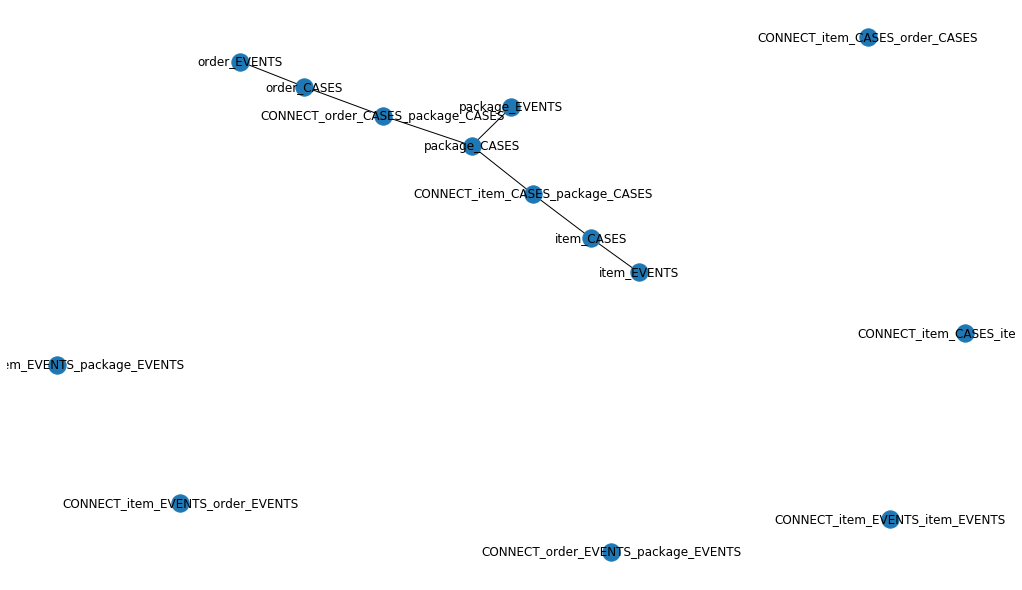

In [48]:
# visualize foreign key graph
plt.figure(figsize=(14,8))
nx.draw(dm.foreignKeyGraph, with_labels = True)

In [49]:
# display data of item_EVENTS table
dm.tables.find("item_EVENTS").getData(shortened_columns=True)

2022-01-22 12:54:11 - pycelonis: PQL Export started...
2022-01-22 12:54:11 - pycelonis: PQL Export status: DONE


,EVID_item,EVID_general,OBJECTS,ACTIVITY,TIMESTAMP,SORT_TIME_item,ATT_EVENT_attr1
0,1.0:item1,1.0,item1,place order,2020-07-09 08:20:00,2020-07-09 08:20:00,attValue
1,2.0:item1,2.0,item1,check availability,2020-07-09 08:21:00,2020-07-09 08:21:00,attValue
2,3.0:item1,3.0,item1,confirm availability,2020-07-09 08:23:00,2020-07-09 08:23:00,attValue
3,1.0:item2,1.0,item2,place order,2020-07-09 08:20:00,2020-07-09 08:20:00,attValue


In [50]:
# group events of item_EVENTS table where activity is "place order" or event equals 2nd event
events = [{"ACTIVITY": "place order"},
         {"OBJECTS": "item1", "ACTIVITY": "check availability", "TIMESTAMP": pd.Timestamp('2020-07-09 08:21:00')}]
dm.groupSpecificEvents("item_EVENTS", events).getData(shortened_columns=True)

,OBJECTS,ACTIVITY,TIMESTAMP
0,"(item1, item2)","(place order, check availability)",2020-07-09 08:21:00
1,item1,confirm availability,2020-07-09 08:23:00


In [51]:
# merge order_EVENTS and item_EVENTS into one activity table
unioned = dm.union("order_EVENTS", "item_EVENTS")
unioned.getData(shortened_columns=True)

2022-01-22 12:54:21 - pycelonis: PQL Export started...
2022-01-22 12:54:21 - pycelonis: PQL Export status: DONE
2022-01-22 12:54:22 - pycelonis: PQL Export started...
2022-01-22 12:54:22 - pycelonis: PQL Export status: DONE
2022-01-22 12:54:25 - pycelonis: PQL Export started...
2022-01-22 12:54:25 - pycelonis: PQL Export status: DONE
2022-01-22 12:54:26 - pycelonis: PQL Export started...
2022-01-22 12:54:26 - pycelonis: PQL Export status: DONE
2022-01-22 12:54:29 - pycelonis: PQL Export started...
2022-01-22 12:54:29 - pycelonis: PQL Export status: DONE
2022-01-22 12:54:30 - pycelonis: PQL Export started...
2022-01-22 12:54:30 - pycelonis: PQL Export status: DONE


,OBJECTS,ACTIVITY,TIMESTAMP
0,"(item1, order1, item2)",place order,2020-07-09 08:20:00
1,(order2),place order,2020-07-09 08:20:00
2,(item1),check availability,2020-07-09 08:21:00
3,(item1),confirm availability,2020-07-09 08:23:00
4,(order1),confirm order,2020-07-09 08:30:00
5,(order1),end order,2020-07-09 08:35:00


In [52]:
# calculate the object relationships between the unioned table and item_EVENTS table
dm.calcObjectRelationships(unioned.name, "item_EVENTS")

,UNION_{order_EVENTS}_AND_{item_EVENTS}_OBJECTS,CASE_item
0,"(item1, order1, item2)",item1
1,"(item1, order1, item2)",item2
2,(item1),item1


In [53]:
# merge unioned table and package_EVENTS into one table
allUnion = dm.union(unioned.name, "package_EVENTS")
allUnion.getData(shortened_columns=True)

2022-01-22 12:54:42 - pycelonis: PQL Export started...
2022-01-22 12:54:43 - pycelonis: PQL Export status: DONE


,OBJECTS,ACTIVITY,TIMESTAMP
0,"(package1, item1, order1, item2)",place order,2020-07-09 08:20:00
1,(order2),place order,2020-07-09 08:20:00
2,(item1),check availability,2020-07-09 08:21:00
3,(item1),confirm availability,2020-07-09 08:23:00
4,(order1),confirm order,2020-07-09 08:30:00
5,(package1),send package,2020-07-09 08:31:00
6,(order1),end order,2020-07-09 08:35:00


In [54]:
# group events with same activity, timestamp of allUnion table
dm.groupEvents(allUnion.name).getData(shortened_columns=True)

,OBJECTS,ACTIVITY,TIMESTAMP
0,"(order2, order1, item2, package1, item1)",place order,2020-07-09 08:20:00
1,(item1),check availability,2020-07-09 08:21:00
2,(item1),confirm availability,2020-07-09 08:23:00
3,(order1),confirm order,2020-07-09 08:30:00
4,(package1),send package,2020-07-09 08:31:00
5,(order1),end order,2020-07-09 08:35:00


In [56]:
# first group order_EVENTS and item_EVENTS and then union two tables
dm.union(dm.groupEvents("order_EVENTS").name, dm.groupEvents("item_EVENTS").name).getData(shortened_columns=True)

,OBJECTS,ACTIVITY,TIMESTAMP
0,"(order2, order1, item1, item2)",place order,2020-07-09 08:20:00
1,(item1),check availability,2020-07-09 08:21:00
2,(item1),confirm availability,2020-07-09 08:23:00
3,(order1),confirm order,2020-07-09 08:30:00
4,(order1),end order,2020-07-09 08:35:00


In [57]:
# first union order_EVENTS and item_EVENTS and then group
dm.groupEvents(dm.union("order_EVENTS", "item_EVENTS").name).getData(shortened_columns=False)

,GROUP{UNION_{order_EVENTS}_AND_{item_EVENTS}}_OBJECTS,GROUP{UNION_{order_EVENTS}_AND_{item_EVENTS}}_ACTIVITY,GROUP{UNION_{order_EVENTS}_AND_{item_EVENTS}}_TIMESTAMP
0,"(order2, item1, order1, item2)",place order,2020-07-09 08:20:00
1,(item1),check availability,2020-07-09 08:21:00
2,(item1),confirm availability,2020-07-09 08:23:00
3,(order1),confirm order,2020-07-09 08:30:00
4,(order1),end order,2020-07-09 08:35:00


In [58]:
####################################################################

# TODO:
### ADD MORE COMMENT (better variable names, clean up...)
### other attributes
### everything based on names, base on tables instead?
### currently only "remembering" tables based on name, can lead to very long and unideal names, especially e.g. for groupSpecificEvents where we use events as encoding. Use e.g. hash function instead?
### create filter, similar like in groupSpecificEvents
### error handling...
### calcObjectRelationships should also save as actual table in tables + foreignKeys + (check if connector table already exists, e.g. by checking that shortest path length is max 3 or based on name again)